# Process reads

### Access the read directory

In [1]:
cd ../raw_data/reads/

/home/lubomir/projects/vampyrella_2023/raw_data/reads


You should now find two files with the ending fastq.gz.

In [2]:
ls

X17007_18S.hifi_reads.fastq.gz


### Unpacking compressed FASTQ files

Unpacked the files with the command below and save the output to:\
Creno_1.fastq\
Creno_2.fastq
\
\
gunzip −c filename.fastq.gz > filename.fastq \
note: “ > ” saves the output in the file filename.fastq. Always replace filename with the name of your file!

In [3]:
!gunzip -c X17007_18S.hifi_reads.fastq.gz > X17007.fastq

In [4]:
ls

X17007_18S.hifi_reads.fastq.gz  X17007.fastq


To check the files, use the commands below and try to answer:\
What is the output for each of the file?\
\
Try one after another and look at the differences.

In [6]:
!cat X17007.fastq | wc -l

24020


In [8]:
!head X17007.fastq

@m54326U_221118_213712/65619/ccs
CTGGTTGATCCTGCCAGTGGCGAAGGTGAAGGTGAGGGTGAAGGTGAGGGTGAAGGTGAGGGTGAAGGTGAGGGTGAAGGTGAACCTGCAGAAGGATCA
+
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~e~~~~~~~~~~~~~~~~~~~~~~
@m54326U_221118_213712/66646/ccs
CTGGTTGATCCTGCCAGCATGCACTGTGTAATGCCCACCACTTGAGAGAGCTGGAGCGTGCATGGGAACAAGACAAGCAGCAATGGGCCGAACAGATTCAGGAGCTGTTGCTGGAAATCAATGATGCAGTCAATGCAGCAGGTGAAAAGCTTAACAATGCAGAGGCTGACGCATTCAGAGAGCGGTACCGACAAATACTGGAAGAGGCAGAAACAGAGTGTCCTCCACCGGATGAGTCAGAACGAAAAAAAGGCCAGAGAGGTCGATTGAAACGATCCAAGGCCAGAAACTTACTGGAGCGCCTGCTCAAGTATGAAGAAGATGTGCTGCGCTTTATGGTGGAGGCCGAGGTGCCGTTTACCAATAATCAGGGCGAGCGGGATCTGCGTATGACCAAGGTGCAGCAAAAGATCTCTGGCTGCTTCCGTTCTGAAAAAGGGGCAATGATGTTTGCTCGCATACGCAGCTATCTCTCCACCTGTCAGAAGAATGGAGTATCCTCTTCTGAGGCTTTGAGACTGCTCTACGAGGGACGGTGGCCTGAGTTTATGGAAATGACCCCTGAATAGTTACAAACAAGTTTATATAGTCGGGACTCAAATAGACATAACTGAACGAAAGAGATCTGAGCAATTTATCTTAAAAACATCAGATATCCTAAGAATGACGGCAGTAGGTGAACCTGCAGAAGGATCA
+
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [10]:
!tail X17007.fastq

+
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~J~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~_~~~~~~~~~~~~~~~~~~~~~~~}~~~~~~~~~~~~~~w~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~i~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~l~~~~~~e~~~~~~~~}~~~~~~~~~~~~~~~~u~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~g~~~~~{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~z~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~r~~~~~~~~~~~~~~6~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~c~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~r~~~~~~~~~~~~~m~y~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~V~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}~~~~~~~~~~~~~~~~~~~~~~~~~M~~~~~~~~~~~~~~~

The commands cat, head, tail, more and less are different commands to see
what the file contains.\
Cat prints the whole file, head the first 10 lines, tail the last 10
lines.\
It might look like more lines, but that depends on the size of
the window, in a smaller window 1 line might appear like 2 and more.\
The number of lines that are returned can be changed with -n, see
head --help.\

So, what is actually shown in the FASTQ files? We already saw it in the lecture. The
file contains the sequence, ID and quality of each read in four rows:
\
@SEQ ID\
GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTT\
+\
!’’*((((***+))%%%++)(%%%%).1***−+* ’’))**55CCF>>>>>>CCCCCCC65\

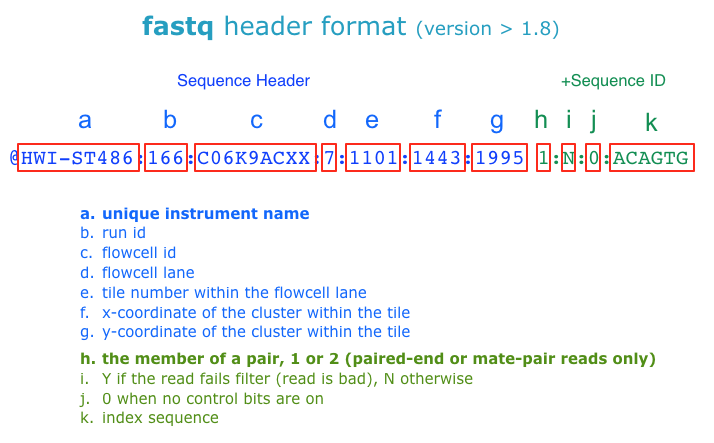

In [6]:
from IPython import display
display.Image("../images/fastq.png")
# From: https://www.gdc-docs.ethz.ch/MDA/site/getdata/

The second row is the actual sequence.\
The third row is mostly represented by a ’+’ or ’+ ID’.\
The fourth row contains the quality values, encoded as ASCII values.\
\
Look at the read ID line and answer the three questions below.

1. What is the instrument name in our FASTQ file?

In [11]:
!head -n 1 X17007.fastq

@m54326U_221118_213712/65619/ccs


<details>
  <summary>Reveal the answer 👀</summary>

The instrument name is DE18INS60511


</details>

2. Are the reads paired? If so, is the file the forward or reverse read?

In [12]:
!head -n 1 X17007.fastq

@m54326U_221118_213712/65619/ccs


In [18]:
!grep "CTGGTTGAT.*CTGCCAGT" X17007.fastq | wc -l

2028


In [17]:
!grep "TGATCCTTCTGCAGGTTCACCTAC" X17007.fastq | wc -l

2379


In [21]:
!grep "@m54326U" X17007.fastq | wc -l

6005


## Transforming a FASTQ into a tabular file

In the FASTQ format, each sequence record take up four lines. It is sometimes more handy to have one sequence record per line and the corresponding sequence data as rows.\
So we will learn how to convert the FASTQ file into tabular format 

In [22]:
ls

X17007_18S.hifi_reads.fastq.gz  X17007.fastq


In [22]:
cat X17007.fastq | paste - - - - > X17007_tab.txt

How does this command work? 😕 \
In the first part, the 'cat' command reads the content of the FASTQ file. Then the content is send as an input to the 'paste' command through the pipe '|' operator. Number of dashes '-' represent how many lines will by converted into the columns/fields. So in our case, the four lines from the old file will be converted into one line in the new file. In this way, we will have one line per sequence record.

To prove that a single line represents a single sequence record we can use the head command and print only a single line:

In [23]:
!head -1 X17007_tab.txt

@m54326U_221118_213712/65619/ccs	CTGGTTGATCCTGCCAGTGGCGAAGGTGAAGGTGAGGGTGAAGGTGAGGGTGAAGGTGAGGGTGAAGGTGAGGGTGAAGGTGAACCTGCAGAAGGATCA	+	~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~e~~~~~~~~~~~~~~~~~~~~~~


We can also print the record per line by using less command with the '-S' option (chop-long-lines), but we cannot navigate through the output using less command here in the jupyter notebook. We can go outside of the jupyter notebook to the command line and use the following command:\
less -S Creno_1_tab.txt

## Quality assessment

In [24]:
pwd

'/home/lubomir/projects/vampyrella_2023/raw_data/reads'

In [25]:
! ../packages/FastQC/fastqc X17007.fastq

Started analysis of X17007.fastq
Approx 15% complete for X17007.fastq
Approx 30% complete for X17007.fastq
Approx 45% complete for X17007.fastq
Approx 65% complete for X17007.fastq
Approx 80% complete for X17007.fastq
Approx 100% complete for X17007.fastq
Analysis complete for X17007.fastq


## Removing adapter sequences and low quality bases and reads

In [33]:
# comment: The output files can be named as you like,
# but replace all parameters in capital letters with the correct numbers,
# adapters and input files

!cutadapt -q 20 -m 50 -p X17007.fastq -o X17007_clean.fastq

4.2


In [28]:
ls

X17007_18S.hifi_reads.fastq.gz  X17007_fastqc.html  X17007_tab.txt
X17007.fastq                    X17007_fastqc.zip
